In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.applications import InceptionResNetV2

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data-ICIAR/Reinhard/train/'
test_dir = "data-ICIAR/Reinhard/test/"

extracted_features_dir = "extracted_features/"
model_name = "Reinhard_InceptionResNetV2_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(validation_dir):
#     print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ICIAR/Reinhard/train/ 0
data-ICIAR/Reinhard/train/Benign 1155
data-ICIAR/Reinhard/train/InSitu 1155
data-ICIAR/Reinhard/train/Invasive 1155
data-ICIAR/Reinhard/train/Normal 1155
******************************
data-ICIAR/Reinhard/test/ 0
data-ICIAR/Reinhard/test/Benign 25
data-ICIAR/Reinhard/test/InSitu 25
data-ICIAR/Reinhard/test/Invasive 25
data-ICIAR/Reinhard/test/Normal 25


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 3468 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3468
nb_validation_samples: 1152

predict_size_train: 109
predict_size_validation: 36
nb_test_samples: 100
predict_size_test: 4

 num_classes: 4


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
model = InceptionResNetV2(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 conv2d_13
51 conv2d_15
52 conv2d_18
53 batch_normalization_13
54 batch_normalization_15
55 batch_normalization

In [12]:
# print(model.layers[11].name)

In [13]:
c1 = model.layers[11].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[18].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[28].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[275].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[618].output
c5 = GlobalAveragePooling2D()(c5) 

con = concatenate([c1, c2, c4, c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [14]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 255, 255, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_101 (BatchN (None, 30, 30, 192)  576         conv2d_101[0][0]                 
__________________________________________________________________________________________________
batch_normalization_104 (BatchN (None, 30, 30, 192)  576         conv2d_104[0][0]                 
__________________________________________________________________________________________________
activation_101 (Activation)     (None, 30, 30, 192)  0           batch_normalization_101[0][0]    
__________________________________________________________________________________________________
activation_104 (Activation)     (None, 30, 30, 192)  0           batch_normalization_104[0][0]    
__________________________________________________________________________________________________
block17_7_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_101[0][0]             
          

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [17]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [18]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3468 samples, validate on 1152 samples
Epoch 1/1000
 - 3s - loss: 1.3526 - acc: 0.3674 - val_loss: 1.2300 - val_acc: 0.3759
Epoch 2/1000
 - 0s - loss: 1.1970 - acc: 0.4441 - val_loss: 1.1276 - val_acc: 0.5139
Epoch 3/1000
 - 0s - loss: 1.1359 - acc: 0.4896 - val_loss: 1.0939 - val_acc: 0.5113
Epoch 4/1000
 - 0s - loss: 1.0927 - acc: 0.5239 - val_loss: 1.0415 - val_acc: 0.5260
Epoch 5/1000
 - 0s - loss: 1.0439 - acc: 0.5522 - val_loss: 0.9795 - val_acc: 0.5842
Epoch 6/1000
 - 0s - loss: 1.0118 - acc: 0.5663 - val_loss: 0.9338 - val_acc: 0.6398
Epoch 7/1000
 - 0s - loss: 0.9560 - acc: 0.6038 - val_loss: 0.8936 - val_acc: 0.6649
Epoch 8/1000
 - 0s - loss: 0.9389 - acc: 0.6101 - val_loss: 0.8802 - val_acc: 0.6727
Epoch 9/1000
 - 0s - loss: 0.8995 - acc: 0.6338 - val_loss: 0.8477 - val_acc: 0.6658
Epoch 10/1000
 - 0s - loss: 0.8753 - acc: 0.6534 - val_loss: 0.8297 - val_acc: 0.7257
Epoch 11/1000
 - 0s - loss: 0.8441 - acc: 0.6724 - val_loss: 0.7784 - val_acc: 0.7092
Epoch 12/1000
 

Epoch 96/1000
 - 0s - loss: 0.2215 - acc: 0.9322 - val_loss: 0.1604 - val_acc: 0.9653
Epoch 97/1000
 - 0s - loss: 0.2259 - acc: 0.9273 - val_loss: 0.1588 - val_acc: 0.9618
Epoch 98/1000
 - 0s - loss: 0.2204 - acc: 0.9328 - val_loss: 0.1548 - val_acc: 0.9635
Epoch 99/1000
 - 0s - loss: 0.2078 - acc: 0.9357 - val_loss: 0.1495 - val_acc: 0.9661
Epoch 100/1000
 - 0s - loss: 0.2115 - acc: 0.9322 - val_loss: 0.1996 - val_acc: 0.9366
Epoch 101/1000
 - 0s - loss: 0.2115 - acc: 0.9351 - val_loss: 0.1503 - val_acc: 0.9661
Epoch 102/1000
 - 0s - loss: 0.2132 - acc: 0.9319 - val_loss: 0.1435 - val_acc: 0.9670
Epoch 103/1000
 - 0s - loss: 0.2022 - acc: 0.9389 - val_loss: 0.1419 - val_acc: 0.9661
Epoch 104/1000
 - 0s - loss: 0.2162 - acc: 0.9311 - val_loss: 0.1418 - val_acc: 0.9714
Epoch 105/1000
 - 0s - loss: 0.2065 - acc: 0.9354 - val_loss: 0.1480 - val_acc: 0.9705
Epoch 106/1000
 - 0s - loss: 0.2022 - acc: 0.9360 - val_loss: 0.1413 - val_acc: 0.9688
Epoch 107/1000
 - 0s - loss: 0.2086 - acc: 0.93

Epoch 191/1000
 - 0s - loss: 0.1045 - acc: 0.9752 - val_loss: 0.0628 - val_acc: 0.9913
Epoch 192/1000
 - 0s - loss: 0.1094 - acc: 0.9723 - val_loss: 0.0610 - val_acc: 0.9939
Epoch 193/1000
 - 0s - loss: 0.1107 - acc: 0.9668 - val_loss: 0.0723 - val_acc: 0.9861
Epoch 194/1000
 - 0s - loss: 0.1083 - acc: 0.9706 - val_loss: 0.0644 - val_acc: 0.9896
Epoch 195/1000
 - 0s - loss: 0.1084 - acc: 0.9720 - val_loss: 0.0601 - val_acc: 0.9913
Epoch 196/1000
 - 0s - loss: 0.1058 - acc: 0.9715 - val_loss: 0.0658 - val_acc: 0.9887
Epoch 197/1000
 - 0s - loss: 0.1073 - acc: 0.9755 - val_loss: 0.0695 - val_acc: 0.9861
Epoch 198/1000
 - 0s - loss: 0.1036 - acc: 0.9746 - val_loss: 0.0521 - val_acc: 0.9922
Epoch 199/1000
 - 0s - loss: 0.1025 - acc: 0.9732 - val_loss: 0.0613 - val_acc: 0.9896
Epoch 200/1000
 - 0s - loss: 0.1023 - acc: 0.9709 - val_loss: 0.0591 - val_acc: 0.9913
Epoch 201/1000
 - 0s - loss: 0.1067 - acc: 0.9726 - val_loss: 0.0604 - val_acc: 0.9922
Epoch 202/1000
 - 0s - loss: 0.1054 - acc: 

 - 0s - loss: 0.0685 - acc: 0.9841 - val_loss: 0.0347 - val_acc: 0.9965
Epoch 286/1000
 - 0s - loss: 0.0672 - acc: 0.9853 - val_loss: 0.0370 - val_acc: 0.9957
Epoch 287/1000
 - 0s - loss: 0.0693 - acc: 0.9827 - val_loss: 0.0299 - val_acc: 0.9974
Epoch 288/1000
 - 0s - loss: 0.0707 - acc: 0.9853 - val_loss: 0.0378 - val_acc: 0.9931
Epoch 289/1000
 - 0s - loss: 0.0740 - acc: 0.9818 - val_loss: 0.0456 - val_acc: 0.9905
Epoch 290/1000
 - 0s - loss: 0.0711 - acc: 0.9847 - val_loss: 0.0362 - val_acc: 0.9957
Epoch 291/1000
 - 0s - loss: 0.0708 - acc: 0.9844 - val_loss: 0.0333 - val_acc: 0.9965
Epoch 292/1000
 - 0s - loss: 0.0686 - acc: 0.9862 - val_loss: 0.0311 - val_acc: 0.9974
Epoch 293/1000
 - 0s - loss: 0.0737 - acc: 0.9841 - val_loss: 0.0312 - val_acc: 0.9965
Epoch 294/1000
 - 0s - loss: 0.0668 - acc: 0.9850 - val_loss: 0.0427 - val_acc: 0.9948
Epoch 295/1000
 - 0s - loss: 0.0642 - acc: 0.9870 - val_loss: 0.0380 - val_acc: 0.9965
Epoch 296/1000
 - 0s - loss: 0.0649 - acc: 0.9873 - val_lo

Epoch 380/1000
 - 0s - loss: 0.0490 - acc: 0.9911 - val_loss: 0.0212 - val_acc: 0.9983
Epoch 381/1000
 - 0s - loss: 0.0470 - acc: 0.9916 - val_loss: 0.0198 - val_acc: 1.0000
Epoch 382/1000
 - 0s - loss: 0.0512 - acc: 0.9885 - val_loss: 0.0216 - val_acc: 1.0000
Epoch 383/1000
 - 0s - loss: 0.0492 - acc: 0.9890 - val_loss: 0.0202 - val_acc: 0.9991
Epoch 384/1000
 - 0s - loss: 0.0506 - acc: 0.9902 - val_loss: 0.0229 - val_acc: 1.0000
Epoch 385/1000
 - 0s - loss: 0.0490 - acc: 0.9905 - val_loss: 0.0213 - val_acc: 0.9991
Epoch 386/1000
 - 0s - loss: 0.0465 - acc: 0.9913 - val_loss: 0.0212 - val_acc: 0.9983
Epoch 387/1000
 - 0s - loss: 0.0484 - acc: 0.9888 - val_loss: 0.0237 - val_acc: 0.9965
Epoch 388/1000
 - 0s - loss: 0.0468 - acc: 0.9908 - val_loss: 0.0218 - val_acc: 0.9991
Epoch 389/1000
 - 0s - loss: 0.0495 - acc: 0.9888 - val_loss: 0.0224 - val_acc: 0.9991
Epoch 390/1000
 - 0s - loss: 0.0548 - acc: 0.9893 - val_loss: 0.0260 - val_acc: 0.9974
Epoch 391/1000
 - 0s - loss: 0.0518 - acc: 

 - 0s - loss: 0.0391 - acc: 0.9913 - val_loss: 0.0158 - val_acc: 1.0000
Epoch 475/1000
 - 0s - loss: 0.0373 - acc: 0.9928 - val_loss: 0.0160 - val_acc: 1.0000
Epoch 476/1000
 - 0s - loss: 0.0450 - acc: 0.9905 - val_loss: 0.0156 - val_acc: 0.9991
Epoch 477/1000
 - 0s - loss: 0.0378 - acc: 0.9928 - val_loss: 0.0165 - val_acc: 0.9965
Epoch 478/1000
 - 0s - loss: 0.0414 - acc: 0.9919 - val_loss: 0.0194 - val_acc: 0.9983
Epoch 479/1000
 - 0s - loss: 0.0398 - acc: 0.9928 - val_loss: 0.0146 - val_acc: 0.9991
Epoch 480/1000
 - 0s - loss: 0.0418 - acc: 0.9922 - val_loss: 0.0156 - val_acc: 0.9991
Epoch 481/1000
 - 0s - loss: 0.0360 - acc: 0.9939 - val_loss: 0.0151 - val_acc: 0.9983
Epoch 482/1000
 - 0s - loss: 0.0367 - acc: 0.9922 - val_loss: 0.0199 - val_acc: 0.9957
Epoch 483/1000
 - 0s - loss: 0.0390 - acc: 0.9934 - val_loss: 0.0151 - val_acc: 0.9983
Epoch 484/1000
 - 0s - loss: 0.0368 - acc: 0.9931 - val_loss: 0.0155 - val_acc: 0.9983
Epoch 485/1000
 - 0s - loss: 0.0367 - acc: 0.9931 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0306 - acc: 0.9957 - val_loss: 0.0117 - val_acc: 0.9991
Epoch 570/1000
 - 0s - loss: 0.0306 - acc: 0.9945 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 571/1000
 - 0s - loss: 0.0309 - acc: 0.9931 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 572/1000
 - 0s - loss: 0.0301 - acc: 0.9960 - val_loss: 0.0116 - val_acc: 1.0000
Epoch 573/1000
 - 0s - loss: 0.0313 - acc: 0.9942 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 574/1000
 - 0s - loss: 0.0321 - acc: 0.9954 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 575/1000
 - 0s - loss: 0.0290 - acc: 0.9963 - val_loss: 0.0099 - val_acc: 1.0000
Epoch 576/1000
 - 0s - loss: 0.0308 - acc: 0.9937 - val_loss: 0.0103 - val_acc: 1.0000
Epoch 577/1000
 - 0s - loss: 0.0310 - acc: 0.9942 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 578/1000
 - 0s - loss: 0.0329 - acc: 0.9939 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 579/1000
 - 0s - loss: 0.0305 - acc: 0.9939 - val_loss: 0.0125 - val_acc: 1.0000
Epoch 580/1000
 - 0s - loss: 0.0305 - acc: 

 - 0s - loss: 0.0297 - acc: 0.9931 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 664/1000
 - 0s - loss: 0.0217 - acc: 0.9971 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 665/1000
 - 0s - loss: 0.0261 - acc: 0.9968 - val_loss: 0.0092 - val_acc: 1.0000
Epoch 666/1000
 - 0s - loss: 0.0261 - acc: 0.9960 - val_loss: 0.0097 - val_acc: 1.0000
Epoch 667/1000
 - 0s - loss: 0.0249 - acc: 0.9968 - val_loss: 0.0150 - val_acc: 1.0000
Epoch 668/1000
 - 0s - loss: 0.0299 - acc: 0.9948 - val_loss: 0.0137 - val_acc: 0.9983
Epoch 669/1000
 - 0s - loss: 0.0251 - acc: 0.9951 - val_loss: 0.0108 - val_acc: 0.9991
Epoch 670/1000
 - 0s - loss: 0.0267 - acc: 0.9948 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 671/1000
 - 0s - loss: 0.0270 - acc: 0.9954 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 672/1000
 - 0s - loss: 0.0237 - acc: 0.9977 - val_loss: 0.0090 - val_acc: 0.9991
Epoch 673/1000
 - 0s - loss: 0.0271 - acc: 0.9951 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 674/1000
 - 0s - loss: 0.0256 - acc: 0.9954 - val_lo

Epoch 758/1000
 - 0s - loss: 0.0239 - acc: 0.9957 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 759/1000
 - 0s - loss: 0.0216 - acc: 0.9963 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 760/1000
 - 0s - loss: 0.0232 - acc: 0.9957 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 761/1000
 - 0s - loss: 0.0207 - acc: 0.9960 - val_loss: 0.0102 - val_acc: 0.9991
Epoch 762/1000
 - 0s - loss: 0.0206 - acc: 0.9968 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 763/1000
 - 0s - loss: 0.0193 - acc: 0.9971 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 764/1000
 - 0s - loss: 0.0212 - acc: 0.9965 - val_loss: 0.0082 - val_acc: 1.0000
Epoch 765/1000
 - 0s - loss: 0.0257 - acc: 0.9954 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 766/1000
 - 0s - loss: 0.0236 - acc: 0.9963 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 767/1000
 - 0s - loss: 0.0205 - acc: 0.9965 - val_loss: 0.0092 - val_acc: 1.0000
Epoch 768/1000
 - 0s - loss: 0.0221 - acc: 0.9971 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 769/1000
 - 0s - loss: 0.0207 - acc: 

 - 0s - loss: 0.0195 - acc: 0.9971 - val_loss: 0.0081 - val_acc: 0.9991
Epoch 853/1000
 - 0s - loss: 0.0214 - acc: 0.9960 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 854/1000
 - 0s - loss: 0.0221 - acc: 0.9963 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 855/1000
 - 0s - loss: 0.0237 - acc: 0.9957 - val_loss: 0.0092 - val_acc: 0.9991
Epoch 856/1000
 - 0s - loss: 0.0193 - acc: 0.9980 - val_loss: 0.0076 - val_acc: 0.9991
Epoch 857/1000
 - 0s - loss: 0.0157 - acc: 0.9971 - val_loss: 0.0064 - val_acc: 0.9991
Epoch 858/1000
 - 0s - loss: 0.0169 - acc: 0.9983 - val_loss: 0.0063 - val_acc: 0.9991
Epoch 859/1000
 - 0s - loss: 0.0182 - acc: 0.9971 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 860/1000
 - 0s - loss: 0.0197 - acc: 0.9968 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 861/1000
 - 0s - loss: 0.0189 - acc: 0.9971 - val_loss: 0.0076 - val_acc: 0.9991
Epoch 862/1000
 - 0s - loss: 0.0192 - acc: 0.9963 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 863/1000
 - 0s - loss: 0.0184 - acc: 0.9968 - val_lo

Epoch 947/1000
 - 0s - loss: 0.0160 - acc: 0.9974 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 948/1000
 - 0s - loss: 0.0182 - acc: 0.9971 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 949/1000
 - 0s - loss: 0.0172 - acc: 0.9968 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 950/1000
 - 0s - loss: 0.0163 - acc: 0.9974 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 951/1000
 - 0s - loss: 0.0187 - acc: 0.9954 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 952/1000
 - 0s - loss: 0.0148 - acc: 0.9974 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 953/1000
 - 0s - loss: 0.0169 - acc: 0.9968 - val_loss: 0.0070 - val_acc: 0.9991
Epoch 954/1000
 - 0s - loss: 0.0194 - acc: 0.9960 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 955/1000
 - 0s - loss: 0.0196 - acc: 0.9960 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 956/1000
 - 0s - loss: 0.0190 - acc: 0.9974 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 957/1000
 - 0s - loss: 0.0183 - acc: 0.9977 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 958/1000
 - 0s - loss: 0.0160 - acc: 

In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.88


Confusion Matrix
[[21  2  0  2]
 [ 2 23  0  0]
 [ 0  3 22  0]
 [ 1  1  1 22]]


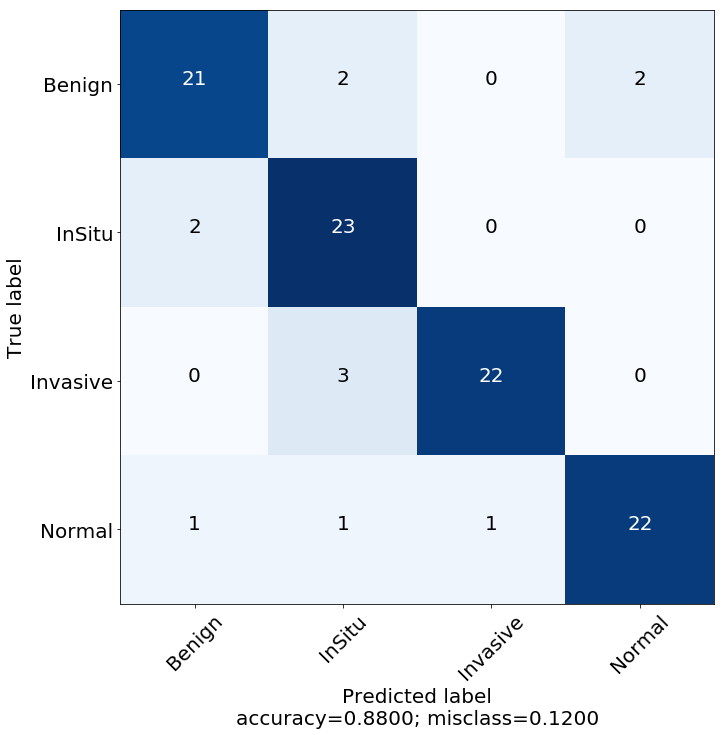

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[21  2  0  2]
 [ 2 23  0  0]
 [ 0  3 22  0]
 [ 1  1  1 22]]
              precision    recall  f1-score   support

      InSitu       0.88      0.84      0.86        25
    Invasive       0.79      0.92      0.85        25
      Normal       0.96      0.88      0.92        25
      Benign       0.92      0.88      0.90        25

   micro avg       0.88      0.88      0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



In [22]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  91.30434782608695
Specificity :  92.0


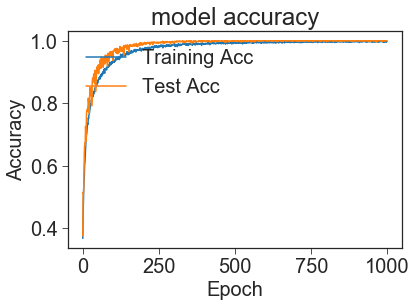

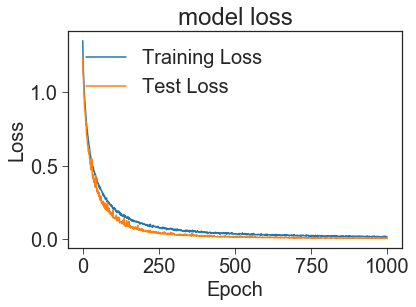

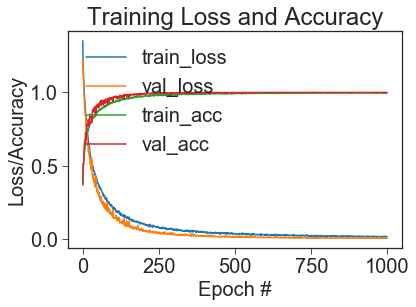

In [23]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")